In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
bs = 64
crop_size = 64 # Hati-hati, 64 ini hanya untuk belajar supaya running g kelamaan. biasanya pakai > 200x200

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [6]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [7]:
# Kalau pakai pure PyTorch

# self.conv = nn.Sequential(
#     nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Flatten()
# )

In [8]:
from jcopdl.layers import conv_block, linear_block

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(64*4*4, 256, dropout=0.2),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [11]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size,
    "labels": label2cat
})

# Training Preparation -> MCOC

In [12]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [13]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch    17
Train_cost  = 0.3783 | Test_cost  = 0.4032 | Train_score = 0.8350 | Test_score = 0.8075 |
==> EarlyStop patience =  1 | Best test_score: 0.8500




Epoch    18
Train_cost  = 0.3590 | Test_cost  = 0.3651 | Train_score = 0.8490 | Test_score = 0.8500 |
==> EarlyStop patience =  2 | Best test_score: 0.8500




Epoch    19
Train_cost  = 0.3657 | Test_cost  = 0.3548 | Train_score = 0.8340 | Test_score = 0.8250 |
==> EarlyStop patience =  3 | Best test_score: 0.8500




Epoch    20
Train_cost  = 0.3602 | Test_cost  = 0.3391 | Train_score = 0.8380 | Test_score = 0.8375 |


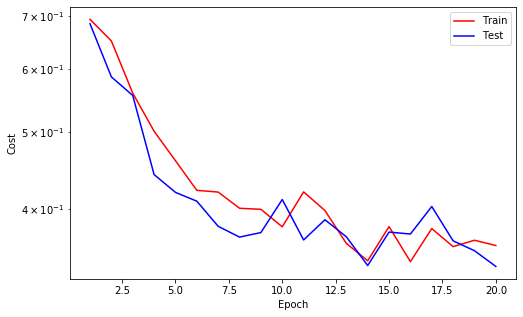

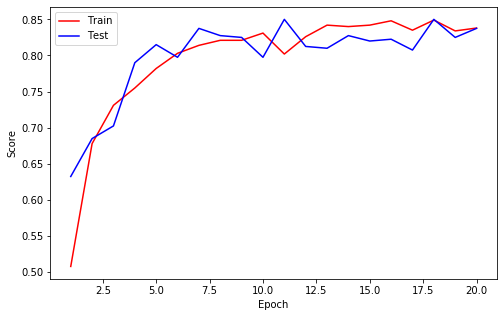

==> EarlyStop patience =  4 | Best test_score: 0.8500




Epoch    21
Train_cost  = 0.3577 | Test_cost  = 0.3669 | Train_score = 0.8400 | Test_score = 0.8400 |
==> EarlyStop patience =  5 | Best test_score: 0.8500
==> Execute Early Stopping at epoch: 21 | Best test_score: 0.8500
==> Best model is saved at model


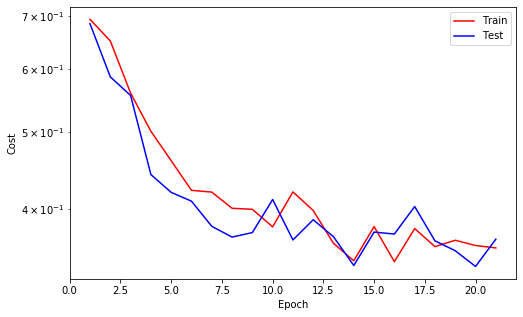

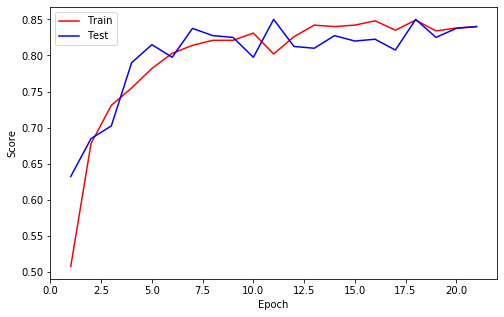

In [16]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Sanity Check

In [17]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

In [18]:
with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)  
preds

tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

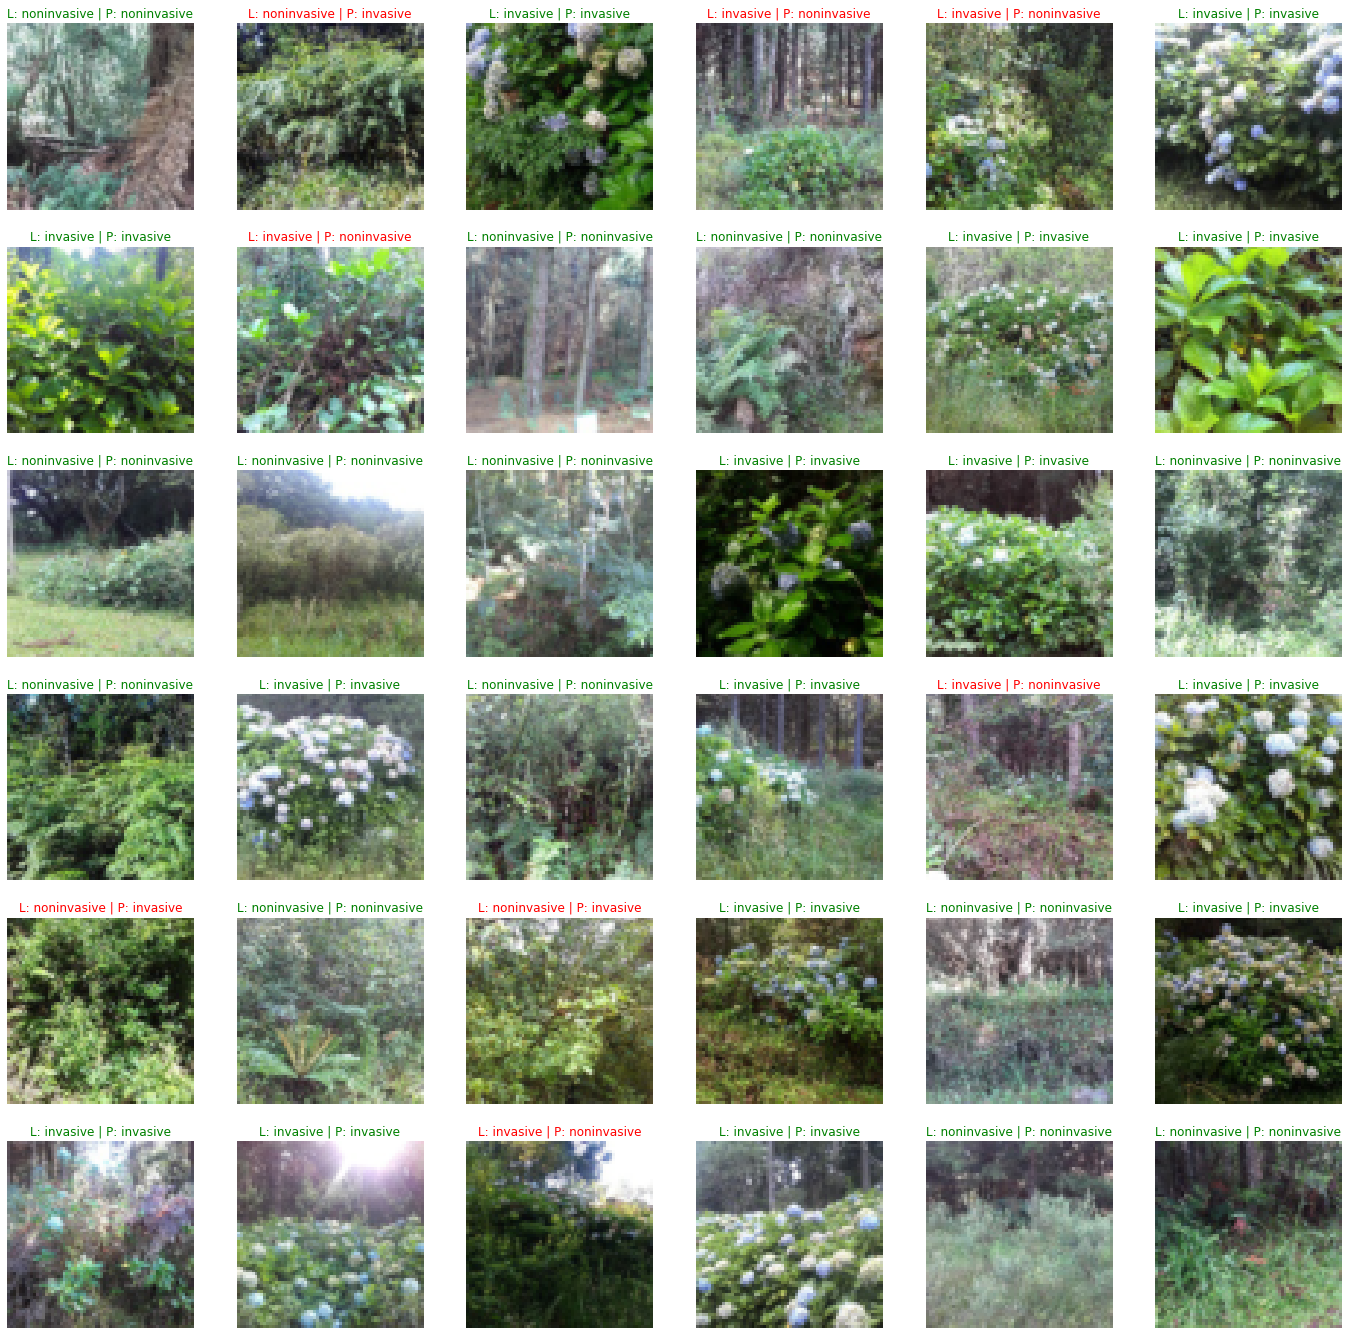

In [19]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');